<a href="https://colab.research.google.com/github/VictorRegueira/AI_Projects/blob/main/BigData/4_3_Avance_de_proyecto_1_Sistema_de_Recomendacion_NETFLIX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Análisis de Grandes Volúmenes de Datos**
###Tecnológico de Monterrey
###Dr. Néstor Velasco Bermeo

## **4.3 Avance de proyecto 1: Sistema de Recomendación**

###**Identificar las diferentes plataformas de Big Data Analytics y sus características para el manejo de tareas de procesamiento de datos a gran escala.**

### **Integrantes:**
#### A01110946 - Fernando Maytorena Espinosa de los Monteros
#### A01793999 - Nathalia Milena Prada Hernández
#### A01794404 - Víctor Alejandro Regueira Romero

**12 de Mayo, 2024**

# Ingesta de datos

In [1]:


import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:


# Skip date
df1 = pd.read_csv('/content/drive/MyDrive/dataset-netflix/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])



Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


 Para este ejemplo solo usaremos 100,000 registros, ya que al usar más de 1,000,000 Colab empieza a fallar al usar la librería Pandas ya que no es la eficiente para BigData

In [10]:
df1.shape

(24058263, 2)

In [11]:
N = 100000
df1 = df1.iloc[:N]

In [12]:
df1.shape

(100000, 2)

In [13]:
# load less data for speed

df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])



Full dataset shape: (100000, 2)
-Dataset examples-
  Cust_Id  Rating
0      1:     NaN


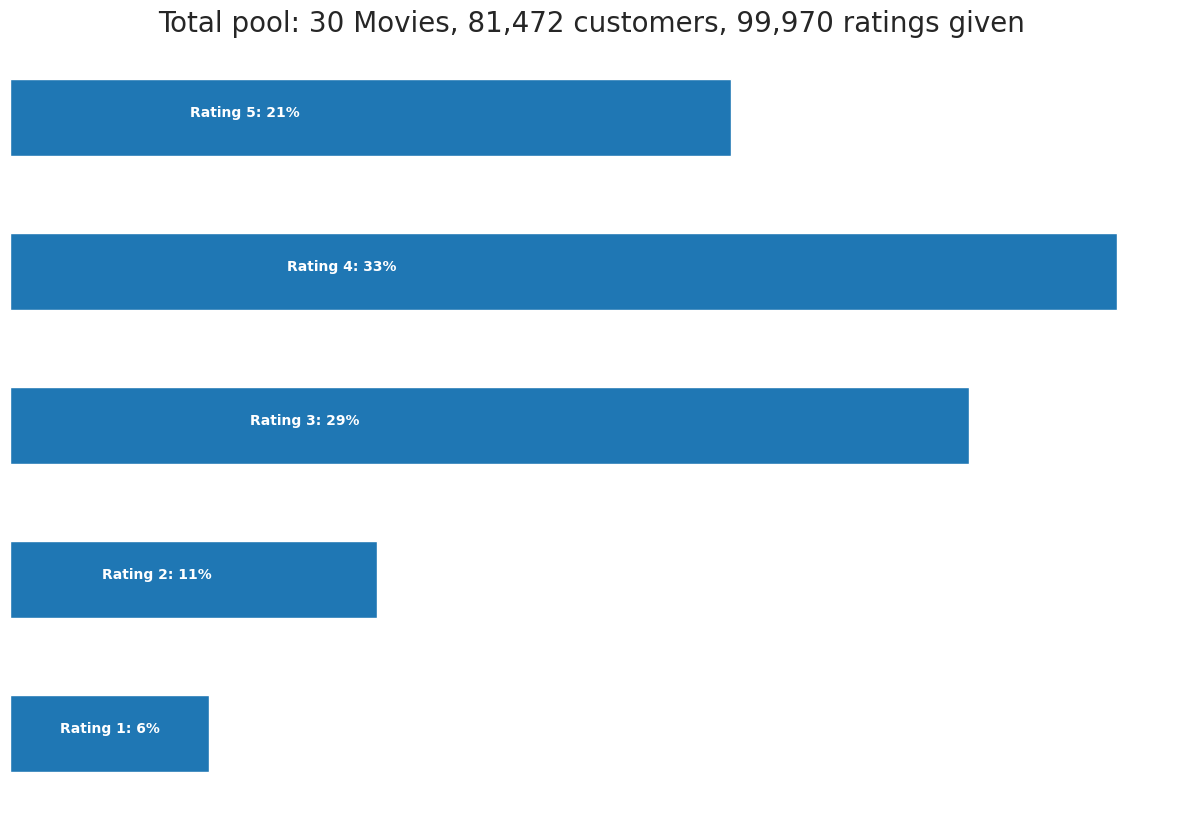

In [14]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

# Data Cleaning

Toma al rededor de 2 minutos en realizarse

In [15]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

# Account for last record and corresponding length
# numpy approach
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [ 1.  1.  1. ... 30. 30. 30.]
Length: 99970


In [16]:


# remove those Movie ID rows
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::50000, :])



-Dataset examples-
       Cust_Id  Rating  Movie_Id
1      1488844     3.0         1
50026  2519993     3.0        26


<ipython-input-16-6f9efce85cd9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie_Id'] = movie_np.astype(int)
<ipython-input-16-6f9efce85cd9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_Id'] = df['Cust_Id'].astype(int)


# Data slicing


- Remove movie with too less reviews (they are relatively not popular)
- Remove customer who give too less reviews (they are relatively less active)


In [17]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1245.0
Customer minimum times of review: 1.0


In [18]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (99970, 3)
After Trim Shape: (91569, 3)
-Data Examples-
     Cust_Id  Rating  Movie_Id
695  1025579     4.0         3


In [19]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

In [20]:
print(df_p.shape)

(77069, 9)


# Data mapping

In [22]:
df_title = pd.read_csv('/content/drive/MyDrive/dataset-netflix/movie_titles.csv', encoding="ISO-8859-1", header=None, names=['Movie_Id', 'Year', 'Name'], usecols=[0, 1, 2])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


# Recommendation models

## Recommend with Collaborative Filtering

**Collaborative filtering (CF)** es una técnica utilizada por los sistemas de recomendación. Tiene dos sentidos, uno más específico y otro más general.

- Sentido estrecho: En este sentido, el filtrado colaborativo se basa en la idea de que si dos usuarios han mostrado preferencias similares en el pasado, es probable que también tengan preferencias similares en el futuro. Por lo tanto, el sistema recomienda elementos a un usuario basándose en las preferencias de usuarios similares. Esto se conoce como CF basado en usuario.

- Sentido más general: Además del CF basado en usuario, hay otro enfoque llamado CF basado en elementos. En este caso, en lugar de comparar la similitud entre usuarios, se calcula la similitud entre los elementos mismos. Por ejemplo, si un usuario ha calificado positivamente una serie de películas, el sistema podría recomendar otras películas similares a las que el usuario ha calificado positivamente, en función de la similitud entre esas películas.

In [23]:
!pip install scikit-surprise

In [24]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [25]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([1.04101995, 1.05129726, 1.04523044, 1.04606836, 1.04234728]),
 'test_mae': array([0.82929128, 0.83791117, 0.83133645, 0.83316095, 0.83473379]),
 'fit_time': (3.457995653152466,
  3.2766404151916504,
  2.658019781112671,
  1.960526704788208,
  2.481391668319702),
 'test_time': (0.25112485885620117,
  0.17699122428894043,
  0.20421433448791504,
  0.381166934967041,
  0.14064407348632812)}

movies that user **783514** liked in the past

In [26]:


df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)



Series([], Name: Name, dtype: object)


Let's predict which movies user 785314 would love to watch:

In [27]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

         Year                                           Name  Estimate_Score
27     2002.0                                Lilo and Stitch        3.211700
8895   2002.0                          Bollywood / Hollywood        2.986284
11853  1939.0                         Only Angels Have Wings        2.986284
11859  1976.0  Bruce Lee: Fists of Fury / Chinese Connection        2.986284
11858  1996.0                       Star Trek: First Contact        2.986284
11857  1974.0                           Good Times: Season 2        2.986284
11856  2000.0                         The Man Show: Season 2        2.986284
11855  1962.0                                    Half Ticket        2.986284
11854  1967.0                                         Hombre        2.986284
11852  1982.0                             Privates on Parade        2.986284
